In [1]:
from datasets import load_dataset, load_from_disk, Dataset
import seaborn as sns
import string
import re

# Load dataset

In [2]:
data = load_dataset("csv", data_files="../Resources/ratings.csv", delimiter=',')
data

Found cached dataset csv (/Users/csr95/.cache/huggingface/datasets/csv/default-022b81eaa8bd774f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['TEXT', 'RATING'],
        num_rows: 10000
    })
})

In [3]:
data['train'][0]

{'TEXT': 'The shirt was more of a smock. I expected a soft little cotton t shirt, but I suppose it\\\'s my fault for not reading the description carefully. Also, the white shirt was completely see through. I returned mine."}},{r:{id:46830320,si:1,pi:10860142,mu:"{f7dedd4c-02d2-49ba-9553-4f9be0bdb9e5}',
 'RATING': 1}

Grab a small random sample to get a quick feel for the type of data we’re working with.

In [4]:
data_sample = data['train'].shuffle(seed=42).select(range(1000))
data_sample[:3]

Loading cached shuffled indices for dataset at /Users/csr95/.cache/huggingface/datasets/csv/default-022b81eaa8bd774f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-0057f7d43c5cb29f.arrow


{'TEXT': ["This bra has been so helpful for pumping at work. I don't know what I would do without it. I like that the size is adjustable, so it can fit anyone..",
  'I love these long sleeve tee shirts. They are my every day go to top. They are nice alone or easy to layer under a sweater. The sleeves run tighter in this color.',
  'I was surprised that the bra was about 2 sizes small. It was supposed to be a 38 but was probably a small 36. The cup size seemed correct but I had to return the item. I could not even try it on. The label inside the bra said 38DD but that certainly was not accurate.'],
 'RATING': [4, 4, 1]}

# Data analysis

In [5]:
for split in data.keys():
    print(split, len(data[split]) == len(data[split].unique('TEXT')))

train False


There are several texts (reviews) repeated.

In [6]:
len(data['train'].unique('TEXT'))

3467

In [7]:
data.set_format("pandas")
df_data = data["train"][:]
print(df_data.shape)
df_data.sample(3)

(10000, 2)


,TEXT,RATING
1912,Runs small and is not wire free side support i...,1
5001,Its ok...I think sized a little small therefor...,3
462,ITEM: Black Skinny Leg Modern Fit - Crafted by...,1


In [8]:
df_data.TEXT.nunique()

3467

In [9]:
df_data.groupby('TEXT')['RATING'].nunique().value_counts()

1    3467
Name: RATING, dtype: int64

Each duplicate review has the same rating.

In [10]:
df_data.isna().sum()

TEXT      0
RATING    0
dtype: int64

In [11]:
df_data.drop_duplicates(inplace=True)
df_data.shape

(3467, 2)

## Ratings distribution

In [12]:
df_data.RATING.value_counts()

4    877
2    681
1    656
3    633
5    620
Name: RATING, dtype: int64

Convert the ratings values to the future predictions the model will return.

In [13]:
df_data.RATING = df_data.RATING - 1

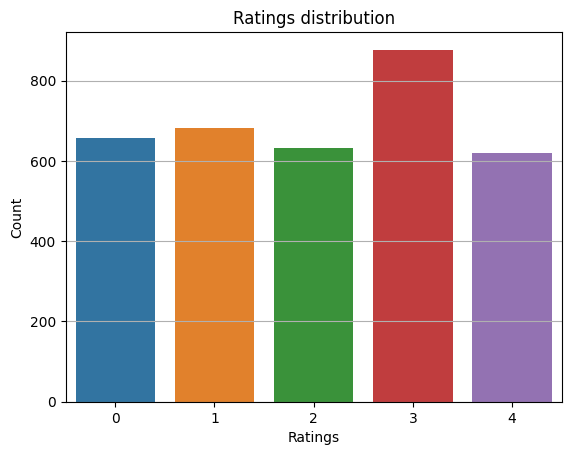

In [14]:
tmp = df_data.RATING.value_counts().to_frame().reset_index().rename(columns={'index':'Ratings', 'RATING':'Count'})
ax = sns.barplot(tmp, x='Ratings', y='Count')
ax.set_title('Ratings distribution')
ax.grid(axis='y');

## Length of text distribution

In [15]:
text_len = df_data.TEXT.apply(lambda review : len(review.split()))
text_len.quantile([0.25, 0.5, 0.75, 0.95, 0.99])

0.25     20.00
0.50     37.00
0.75     60.00
0.95    107.00
0.99    164.02
Name: TEXT, dtype: float64

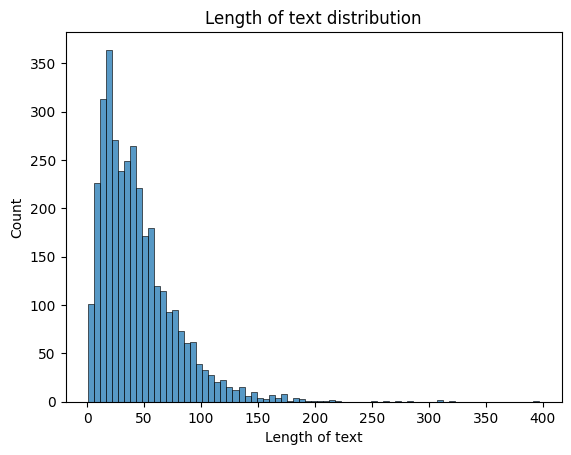

In [16]:
ax = sns.histplot(text_len)
ax.set_title("Length of text distribution")
ax.set_xlabel("Length of text");

Back to Dataset

In [17]:
data_lite = Dataset.from_pandas(df_data, preserve_index=False)
data_lite

Dataset({
    features: ['TEXT', 'RATING'],
    num_rows: 3467
})

## Clean/preprocess text

1. Convert to lowercase.
2. Remove the following matches:
    - mentions (@[A-Za-z0-9]+)
    - hashtags (@[A-Za-z0-9]+)
    - links and any other pattern that has a ':' character in the middle (\.\S+:\S+)|(\,\S+:\S+)|(\w+:\S+)|(^\S+:\S+)
    - patterns that combine letters and digits ([A-Za-z]+[0-9]+)|([0-9]+[A-Za-z]+)
3. Skip some punctuation characters.
    ```
        string.punctuation.replace('!','').replace('?','').replace("'",'').\
                           replace(',','').replace('.','').replace(':','').\
                           replace('(','').replace(')','').replace(';','')
    ```
    Returns: "#$%&*+-/<=>@[\\]^_`{|}~
4. Skip whitespaces at the beginning or at the end.

In [18]:
def clean_text_and_calculate_length(text):
    cleaned_text = text['TEXT'].lower()
    cleaned_text = re.sub(r"(@[a-z0-9]+)|(#[a-z0-9]+)|(\.\S+:\S+)|(\,\S+:\S+)|(\w+:\S+)|(^\S+:\S+)|([a-z]+[0-9]+)|([0-9]+[a-z]+)", "", cleaned_text)
    to_remove = string.punctuation.replace('!','').replace('?','').replace("'",'').\
                                   replace(',','').replace('.','').replace(':','').\
                                   replace('(','').replace(')','').replace(';','')
    cleaned_text = cleaned_text.translate(str.maketrans('', '', to_remove))
    cleaned_text = cleaned_text.strip()
    
    return {"CLEANED_TEXT": cleaned_text, "TEXT_LENGTH": len(cleaned_text.split())}

In [19]:
data_lite = data_lite.map(clean_text_and_calculate_length)
data_lite[:2]

Map:   0%|          | 0/3467 [00:00<?, ? examples/s]

{'TEXT': ['The shirt was more of a smock. I expected a soft little cotton t shirt, but I suppose it\\\'s my fault for not reading the description carefully. Also, the white shirt was completely see through. I returned mine."}},{r:{id:46830320,si:1,pi:10860142,mu:"{f7dedd4c-02d2-49ba-9553-4f9be0bdb9e5}',
  "Just received my order today. When I opened the package it appeared used to me. The product packaging was wrinkled and the way it was folded inside looked as if someone had just stuffed in the package. When I took it out of the package to put it on, the velcro wouldn't stick. Upon further inspection I realized that the velco was on the wrong side of the belt. It had ripped off of the correct side and stuck to the fuzzy part, which was proof someone had tried to use it before me and this is what happened.....probably why they returned it. Piece of garbage. Will return it to the store as soon as I can and I will order another brand from another store. Very disappointing because I am ca

## Filter reviews by the length of the text

In [20]:
data_lite.filter(lambda review : review["TEXT_LENGTH"] < 6).shuffle()[:20]

Filter:   0%|          | 0/3467 [00:00<?, ? examples/s]

{'TEXT': ['Very cute and comfty',
  'Thin fabric but quite attractive.',
  "I'm 5\\",
  'They are very comfortable pants!',
  'I say \\',
  'great price! great shirt!',
  'Hugs hips true to size',
  'GREAT PRICE AND GREAT SHIRT!',
  "I am 5'5\\",
  'I bought this \\',
  'Fell apart after one wash!!!!!',
  "I'm 5'3\\",
  'Runs a little small.',
  'comfortable fit and washes well',
  'This has been my \\',
  'Amazing prints and comfy!!!',
  'love love love this dress....',
  'Comfortable hope they last',
  'Freezing NY winters - Warm enough??',
  'Just exactly what I expected.'],
 'RATING': [4, 3, 4, 3, 3, 4, 4, 4, 0, 1, 0, 3, 3, 4, 2, 4, 4, 4, 4, 4],
 'CLEANED_TEXT': ['very cute and comfty',
  'thin fabric but quite attractive.',
  "i'm 5",
  'they are very comfortable pants!',
  'i say',
  'great price! great shirt!',
  'hugs hips true to size',
  'great price and great shirt!',
  "i am 5'5",
  'i bought this',
  'fell apart after one wash!!!!!',
  "i'm 5'3",
  'runs a little small.',


From 6 words onwards it may be possible to extract useful information from the reviews. Besides, this operation doesn't remove too many reviews which are valuable for the training and validation process.

In [21]:
data_lite = data_lite.filter(lambda review : review["TEXT_LENGTH"] > 6)
data_lite

Filter:   0%|          | 0/3467 [00:00<?, ? examples/s]

Dataset({
    features: ['TEXT', 'RATING', 'CLEANED_TEXT', 'TEXT_LENGTH'],
    num_rows: 3360
})

We need to rename the labels column to what the model expects. In the case of the `bert-base-uncased` is `label`.

In [22]:
data_lite = data_lite.remove_columns(['TEXT', 'TEXT_LENGTH']).rename_column('CLEANED_TEXT', 'text').rename_column('RATING', 'label')
data_lite

Dataset({
    features: ['label', 'text'],
    num_rows: 3360
})

# Create validation and evaluation datasets

In [23]:
# First create train (80%) and text (20%) datasets
dataset_dict = data_lite.train_test_split(train_size=0.8, seed=42)
# Rename validation dataset
dataset_dict['validation'] = dataset_dict.pop('test')
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 2688
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 672
    })
})

In [24]:
dataset_dict.save_to_disk("../Resources/ratings_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/2688 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/672 [00:00<?, ? examples/s]

In [25]:
dataset_dict_reloaded = load_from_disk("../Resources/ratings_dataset")
dataset_dict_reloaded

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 2688
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 672
    })
})